# ДЗ 3

Домашнее задание
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Ссылки
https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
https://en.wikipedia.org/wiki/Receiver_operating_characteristic


In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


Объективные признаки:

    Возраст
    Рост
    Вес
    Пол

Результаты измерения:

    Артериальное давление верхнее и нижнее
    Холестерин
    Глюкоза

Субъективные признаки:

    Курение
    Употребление Алкоголя
    Физическая активность


In [13]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))
    
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
y_train.value_counts(normalize=True)

1    0.500933
0    0.499067
Name: cardio, dtype: float64

In [5]:
y_test.value_counts(normalize=True)

0    0.504
1    0.496
Name: cardio, dtype: float64

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [14]:
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [15]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 0)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [16]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


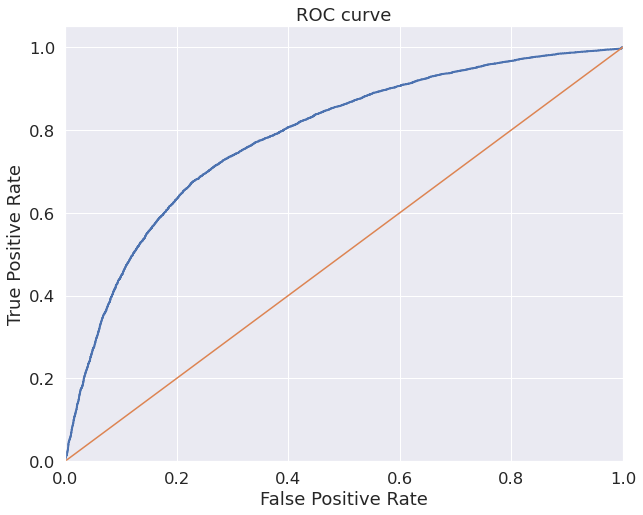

In [21]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [23]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230665


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


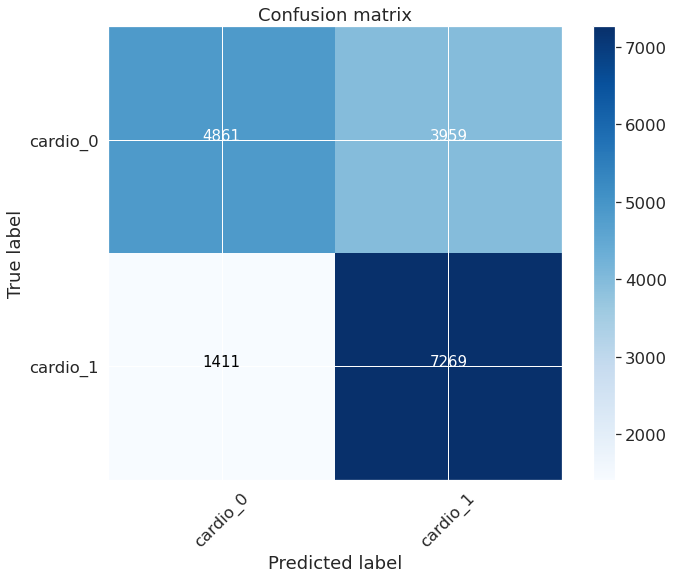

In [28]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [56]:
relative_df = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'roc_auc', 'cv_roc_auc', 'cv_roc_auc_std'])

In [57]:
log_reg_model = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=0)),
])

In [58]:
def any_model (model, X_train, X_test, y_train, y_test):

    cv_scores = cross_val_score(model, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    # Train model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Find optimal threshold
    beta = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
    f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    ix = np.argmax(f1)

    # Show ROC curve
#     show_roc_curve(y_test, y_pred)
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

    # Return metrics
    return {
            'precision': precision[ix],
            'recall': recall[ix],
            'f1_score': f1[ix],
            'roc_auc': roc_auc_score(y_test, y_pred),
            'cv_roc_auc': cv_score,
            'cv_roc_auc_std': cv_score_std
           }

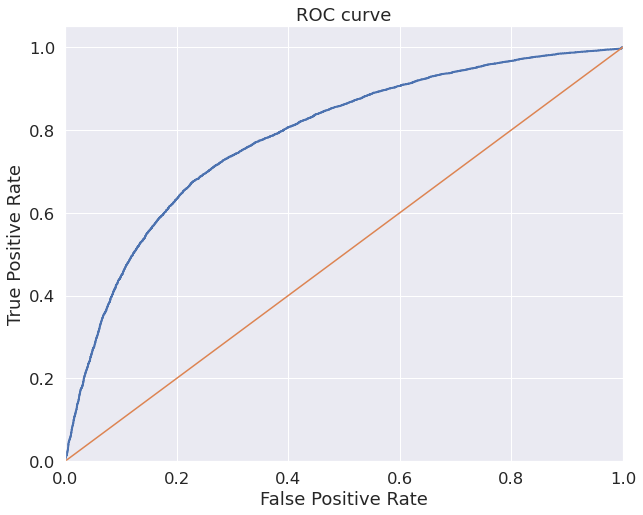

In [59]:
output_lr = any_model(log_reg_model, X_train, X_test, y_train, y_test)
relative_df = relative_df.append(output_lr, ignore_index=True)

In [60]:
relative_df

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std
0,0.647431,0.837558,0.730323,0.784035,0.786457,0.004422


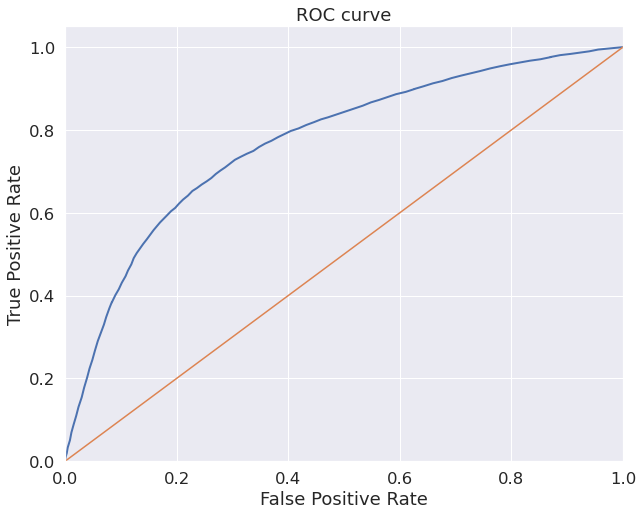

In [61]:
rand_forest_model = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=0)),
])

output_rf = any_model(rand_forest_model, X_train, X_test, y_train, y_test)
relative_df = relative_df.append(output_rf, ignore_index=True)

In [62]:
relative_df

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std
0,0.647431,0.837558,0.730323,0.784035,0.786457,0.004422
1,0.659773,0.797581,0.722161,0.770831,0.774361,0.003212


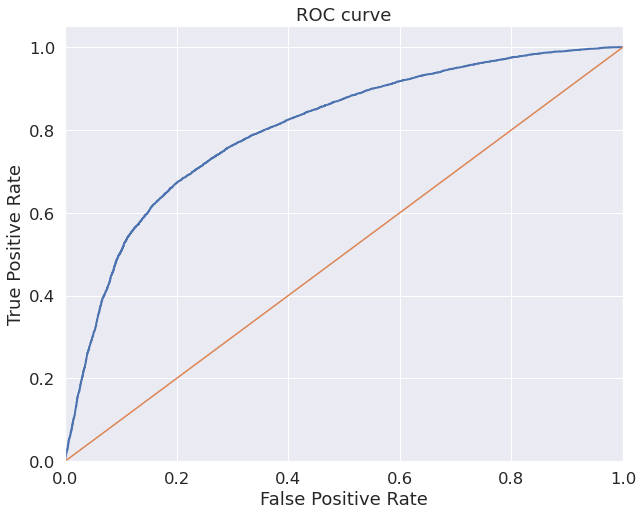

In [63]:
GBC_model = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=0)),
])

output_gb = any_model(GBC_model, X_train, X_test, y_train, y_test)
relative_df = relative_df.append(output_gb, ignore_index=True)

In [64]:
relative_df

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std
0,0.647431,0.837558,0.730323,0.784035,0.786457,0.004422
1,0.659773,0.797581,0.722161,0.770831,0.774361,0.003212
2,0.697848,0.788134,0.740248,0.802617,0.802337,0.003075


In [67]:
relative_df['model'] = ['Log Reg', 'Rand For', 'GBC']
relative_df = relative_df.set_index('model')
relative_df

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std
model,,,,,,
Log Reg,0.647431,0.837558,0.730323,0.784035,0.786457,0.004422
Rand For,0.659773,0.797581,0.722161,0.770831,0.774361,0.003212
GBC,0.697848,0.788134,0.740248,0.802617,0.802337,0.003075


In [68]:
y_train.value_counts(normalize=True)

1    0.500933
0    0.499067
Name: cardio, dtype: float64

Классы сбалансированны в данном датасете, то есть людей с ССЗ и без +- одинаково. Думаю, что важнее в данной задаче предугадать максимальное кол-во больных(True Positive), пусть в ответ даже попадут и здоровые (False Positive). 

recall=$\frac{TP}{TP+FN}$

А следовательно нас интересует больше метрика RECALL.
Данную метрику лучше показала модель логистической регрессии.
Также считаю, что для повышения эффективности модели  по цели задачи имеет смысл подкрутить threshold, увеличив RECALL в ущерб другим метрикам.